<h1><font color='darkblue'> Predicting Baseline Hot Water Consumption Using LSTM Model</font></h1>

<p><strong>Forecasting building energy consumption</strong> has immense value in energy efficiency and sustainability research. Accurate energy forecasting models have numerous implications in planning and energy optimization of buildings and campuses.<p>

New buildings, where past recorded is unavailable, rely on computer simulations to perform energy data analysis and forecasting future consumption. However, existing buildings with recorded energy consumption, statistical and machine learning techniques have proved to be more accurate and quick forecasting methods. 

This is why this machine learning capstone project cames in handy - to better forecast the baseline energy consumption based on historical data. 

<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="imports">Imports</a></li>
        <li><a href="dataset">Loading the Dataset</a></li>
        <ul>
            <li><a href="office">Office wiith Building_id = 1249</a></li>
        </ul>
        <li><a href="electricity">Hot Water Consumption</a></li>
        <li><a href="dataset">Dataset Scaling</a></li>
        <li><a href="data">Data Generator</a></li>
        <li><a href="LSTM">Create Recurrent Neural Network => LSTM Consumption</a></li>
         <ul>
            <li><a href="instantiation">Instantiate the LSTM Model</a></li>
            <li><a href="layers">Adding LSTM Layers</a></li>
            <li><a href="callbacks">Callback Functions</a></li>
            <li><a href="fit">Fittitting the LSTM Model</a></li>
        </ul>
        <li><a href="evaluate">Evaluate the LSTM Model</a></li>
        <li><a href="plot">Plot the Actual vs Predicted Sequential Data</a></li>
        <li><a href="loss">Plot Model Loss</a></li>
        <li><a href="conclusion">Conclusion</a></li>
        <li><a href="feature works">Feature Works...</a></li>
    </ul>
    <p>
        Estimated read time: <strong>25 min</strong>
    </p>
</div>

<hr>

<h2 id="imports"><font color='darkblue'>Imports</font></h2>

In [1]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)

# Visualization packages:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import datetime as dt
from IPython.display import HTML # to see everything

import scikit learn

In [2]:
# import packages from sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

# autorelaod function
%load_ext autoreload
%autoreload 2

import TensorFlow and Keras Keras API 

In [4]:
import tensorflow as tf

# import Sequential
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                               TensorBoard, ReduceLROnPlateau, CSVLogger)
# print 
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta0
2.2.4-tf


import diffiened functions

In [5]:
import visualization as vis 
import helper_function as f 
import data_cleaning as dc 

<h2 id="dataset"><font color='darkblue'> Loading the Dataset</font></h2>

In [6]:
use_cols =['timestamp', 'building_id', 'meter', 'meter_reading', 'air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
training_data = pd.read_csv("data/energy_consumption_data.csv", usecols=use_cols, index_col=['timestamp'], parse_dates=['timestamp'])#parse_dates=['timestamp'])
print("Dataset shapes: ", training_data.shape)

Dataset shapes:  (20216100, 10)


<p>In this notebook, we are going to focusing on one particular office building and create an LSTM machine learning model to predict the baseline electricity consumption for this particular bulding. The chosen office building has all the four meter reading <font color='darkred'>(<strong>'Steam', 'Electricity', 'Hotwater'</strong> and <strong>'Chilled Water')</strong></font> and has a building id <code><strong>building_id = 1249</strong></code></p>

<h3 id="office"><font color='darkblue'>Office wiith Building_id = 1249</font></h3>

In [9]:
office_building_1249 = training_data[training_data['building_id'] == 1249].drop(columns=['building_id'])#.ffill()
office_building_1249['meter'] = pd.Categorical(office_building_1249['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
print('DataFrame shape for building_id = 1249 is: ', office_building_1249.shape)
office_building_1249.head()

DataFrame shape for building_id = 1249 is:  (35136, 9)


,meter,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,
2016-01-01 00:00:00,electricity,299.000,nan,nan,nan,nan,nan,nan,nan
2016-01-01 00:00:00,chilledwater,695.555,nan,nan,nan,nan,nan,nan,nan
2016-01-01 00:00:00,steam,899.640,nan,nan,nan,nan,nan,nan,nan
2016-01-01 00:00:00,hotwater,840.861,nan,nan,nan,nan,nan,nan,nan
2016-01-01 01:00:00,electricity,298.000,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600


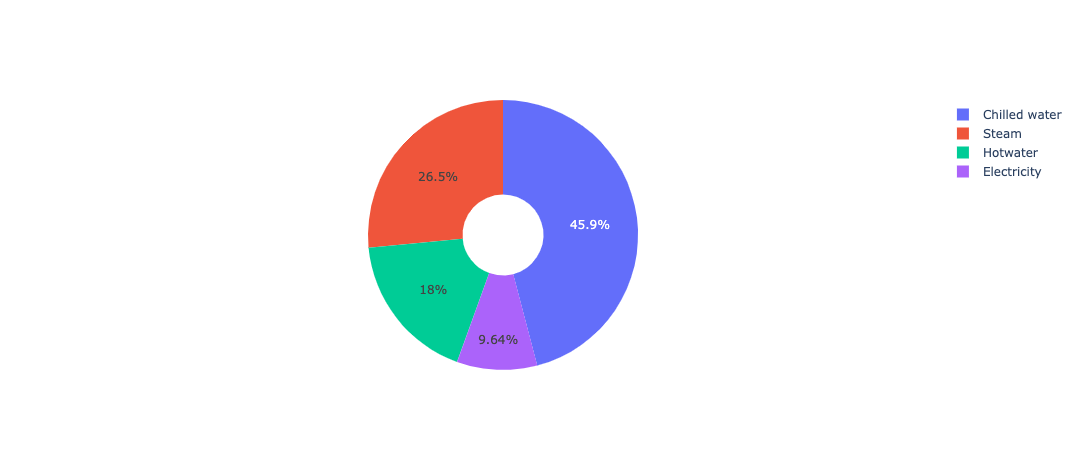

In [10]:
import plotly.graph_objs as go 
labels = 'Electricity', 'Chilled water', 'Steam', 'Hotwater'
sizes = list(office_building_1249.groupby(by='meter')['meter_reading'].sum())
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=.3)])
fig.show()

<h2 id="electricity"><font color='darkblue'>Hot Water Consumption</font></h2>

In [12]:
hotwater_consumption = office_building_1249[office_building_1249['meter'] == 'hotwater'].drop(columns=['meter']).ffill()
hotwater_consumption = hotwater_consumption.bfill()
print("Taking out the hot water portion out of total building energy consumption, the new dataset has a shape of:", hotwater_consumption.shape)

Taking out the hot water portion out of total building energy consumption, the new dataset has a shape of: (8784, 8)


... plotting for electricity consumption

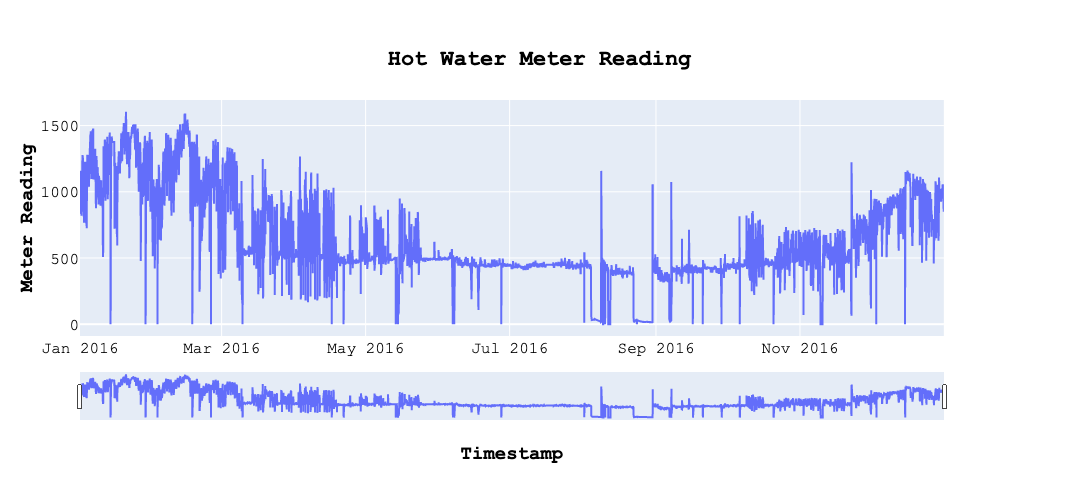

In [13]:
from plotly.subplots import make_subplots

# hotwater_consumption['meter_reading'].replace(to_replace=0, method='ffill', inplace=True)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=hotwater_consumption.index,
                         y=hotwater_consumption['meter_reading'],
                         name="Actual")) #line_color='lightblue'
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(width=1000, height=500,
                      title= {'text': "<b>Hot Water Meter Reading<b>", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title="<b>Timestamp<b>",
                      yaxis_title="<b>Meter Reading<b>",
                      font=dict(family="Courier New, monospace", size=16, color='black'))
fig.show()

<p>In this section, we will try to create a deep learning model to predict the feature  (24-hour) hot water consumption as a function of building animities,  weather data, and historical meter data.</p>

<p>Let's first shift the sequence by 24-hours or one day</p>

In [14]:
# take out target variable
target_variable = ['meter_reading']
shift_days = 1
shift_steps = shift_days * 24 # we shift the record by shift_steps hours.
target_data = hotwater_consumption[target_variable].shift(-shift_steps)
target_data.head(3)

,meter_reading
timestamp,
2016-01-01 00:00:00,1164.430
2016-01-01 01:00:00,1277.750
2016-01-01 02:00:00,1167.290


<p>let's check if we successfully shifted our target variable by <strong>24-hours</strong></p>. 

In [16]:
# check the raws from 24- 27
hotwater_consumption.iloc[24:27]

,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-02 00:00:00,1164.430,2.800,4.000,-6.100,0.000,1017.000,280.000,3.600
2016-01-02 01:00:00,1277.750,2.200,4.000,-6.700,0.000,1017.500,290.000,3.100
2016-01-02 02:00:00,1167.290,1.100,0.000,-6.700,0.000,1018.000,280.000,3.100


good! looking at the meter reading for **index [24:27]**. We can now see we successfully shifted the target variable by **24 -hours**. Let's move on to splitting the dataset into training and test sets.

In [17]:
# feature set 
x_data = hotwater_consumption.values[0:-shift_steps]
print('\t Feature set shapes:', x_data.shape)
 
# target set
y_data = target_data.values[:-shift_steps]
print('\t Target set shapes:', y_data.shape)

	 Feature set shapes: (8760, 8)
	 Target set shapes: (8760, 1)


awesome... let's train_test_split the sets at <font color='darkred'><strong>85%</strong></font>, where ***85%*** will be sued as a ***training set*** and the remaing remaining ***15%*** will be used as a ***validation set***.

In [18]:
# These are the input-signals for the training- and test-sets:
num_data = len(x_data)
train_split = 0.85
num_train = int(train_split * num_data)
num_test = num_data - num_train
print("Training set has {} observations".format(num_train))
print("Validation set has {} observations".format(num_test))
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print("Total number of observations: {}".format(sum([len(x_train),len(x_test)])))

Training set has 7446 observations
Validation set has 1314 observations
Total number of observations: 8760


output signals for the training and test sets will look like

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print('Total test observations:', (len(y_train) + len(y_test)))
# y_train_elec.shape, y_test_elec.shape
num_x_signals = x_data.shape[1] # 8
num_y_signals = y_data.shape[1] # 1
print('There are {} input-signals and the input shapes is like: {}'.format(num_x_signals, x_train.shape ))
print('There are {} output-signals and the output shapes is like: {}'.format(num_y_signals, y_train.shape ))

Total test observations: 8760
There are 8 input-signals and the input shapes is like: (7446, 8)
There are 1 output-signals and the output shapes is like: (7446, 1)


<h2 id="dataset"><font color='darkblue'>Dataset Scaling</font></h2>

<p>the records in the datasets are not on the same scale, so we need to scale the data before moving forward. Min_Max scaler is the appropriate data scaling procedure for this kind of sequential data. So, let's scale the data.</p>

In [20]:
print('Min and Max x_train for hot water consumption')
print('    Min:', np.min(x_train))
print('    Max:', np.max(x_train))
x_scaler = MinMaxScaler() # feature_range=(0, 1)
x_scaled_train = x_scaler.fit_transform(x_train)
print('Min and Max x_train_scaled for hot water consumption')
print('    Min:', np.min(x_scaled_train))
print('    Max:', np.max(x_scaled_train))

Min and Max x_train for hot water consumption
    Min: -25.6
    Max: 1604.06
Min and Max x_train_scaled for hot water consumption
    Min: 0.0
    Max: 1.0


In [21]:
x_scaled_test = x_scaler.transform(x_test)
print('Min and Max x_test data')
print('    Min:', np.min(x_test))
print('    Max:', np.max(x_test))

# target MinMaxScaler
y_scaler = MinMaxScaler() # feature_range=(-1, 1)
y_scaled_train = y_scaler.fit_transform(y_train)
y_scaled_test = y_scaler.transform(y_test)
print('Min and Max y_test_scaled data')
print('    Min:', np.min(y_scaled_test))
print('    Max:', np.max(y_scaled_test))

Min and Max x_test data
    Min: -23.3
    Max: 1223.9
Min and Max y_test_scaled data
    Min: 0.0
    Max: 0.7630013839881302


<p><strong>Note:</strong> The set we have now is one long-time series with 8 input signals and one output signal.</p>

<h2 id="data"><font color='darkblue'>Data Generator</font></h2>

LSTM input layer expects a 3D array of data when fitting a model and making predictions. This *three-dimensional array* makes the LSTM model a bit confusing and difficult to understand. 

Let's see what is constituted in this three-dimensional array: 

* <font color='darkred'><b>Samples.</b></font> One sequence is one sample. A batch is comprised of one or more samples.
* <font color='darkred'><b>Time Steps.</b></font> One time step is one point of observation in the sample.
* <font color='darkred'><b>Features.</b></font> One feature is one observation at a time step.

The ***batch_generater()*** method inside the ***helper_function.py*** will break the above long sequence into batches so that we can easily use them to train the LSTM network.

```python 
LSTM input shape: [samples, time steps, features]
```

In [22]:
import helper_function as f

In [23]:
batch_generator = f.batch_generator(batch_size=64, sequence_length=24, num_train= num_train,
                                         x_scaled_train=x_scaled_train,
                                         y_scaled_train=y_scaled_train)

In [24]:
x_batch, y_batch = next(batch_generator)
print("Shape of x_training_set", x_batch.shape)
print("Shape of y_training_set", y_batch.shape)

Shape of x_training_set (64, 24, 8)
Shape of y_training_set (64, 24, 1)


we have to expand the validation/test set to three-dimensions as well. we do this as follows

In [25]:
validation_data = (np.expand_dims(x_scaled_test, axis=0),
                   np.expand_dims(y_scaled_test, axis=0))
print("Shape of x_test_validation", validation_data[0].shape)
print("Shape of y_test_validation", validation_data[1].shape)

Shape of x_test_validation (1, 1314, 8)
Shape of y_test_validation (1, 1314, 1)


<h2 id="LSTM"><font color='darkblue'>Create Recurrent Neural Network => LSTM</font></h2>

import <b>sequential models</b> from the Keras API

In [26]:
from tensorflow.python.keras.models import Sequential

<h3 id="instantiation"><font color='darkblue'>Instantiate the LSTM Model</font></h3>
Now let's instantiate the Keras API 

In [27]:
# use this code to clear the model and start building a new model arcthecture 
tf.keras.backend.clear_session()

In [28]:
# instantiate the squential model 
hotwater_prediction_model = Sequential()

<h3 id="layers"><font color='darkblue'>Adding LSTM Layers</font></h3>

In [29]:
from keras import regularizers

Using TensorFlow backend.


In [30]:
# adding the first LSTM layer
hotwater_prediction_model.add(LSTM(units=100, return_sequences=True, dropout=0.4,
                            input_shape=(None, num_x_signals,)))

In [31]:
# Adding the second LSTM layer
hotwater_prediction_model.add(LSTM(units=100, return_sequences=True, dropout=0.4))

In [32]:
# Adding the thired LSTM layer
hotwater_prediction_model.add(LSTM(units=100, return_sequences=True, dropout=0.5))

In [33]:
# Adding the dense layer
hotwater_prediction_model.add(Dense(num_y_signals, activation='sigmoid'))

<h3 id="complie"><font color='darkblue'>Compile the LSTM Model</font></h3>

In [34]:
optimizer = RMSprop(lr=1e-3)
hotwater_prediction_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
hotwater_prediction_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         43600     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 204,501
Trainable params: 204,501
Non-trainable params: 0
_________________________________________________________________


<h3 id="callbacks"><font color='darkblue'>Callback Functions</font></h3>

In [35]:
path_checkpoint = 'weights/model_weights_hotwater_predictor_model.h5'
# checkpoint callbacks
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
# early stopping callbacks
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
# tensorboard callbacks
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
# reduce linear regression on plateau callbacks
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

... save the log information into CSV logger

In [36]:
csv_logger = CSVLogger('logs/hotwater_predictor_model.csv')

In [37]:
# create a callback list  
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard,
             callback_reduce_lr, csv_logger]

<h3 id="fit"><font color='darkblue'>Fitting the LSTM Model</font></h3>

In [39]:
%%time
hotwater_dropout_history = hotwater_prediction_model.fit_generator(generator=batch_generator,
                    epochs=20, steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 99/100 [============================>.] - ETA: 0s - loss: 0.0336 - mse: 0.0336
Epoch 00001: val_loss improved from inf to 0.01853, saving model to weights/model_weights_hotwater_predictor_model.h5
100/100 [==============================] - 27s 274ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0257 - mse: 0.0257
Epoch 00002: val_loss did not improve from 0.01853

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 13s 133ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0224 - mse: 0.0224
Epoch 00003: val_loss did not improve from 0.01853

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [========

<h2 id="evaluate"><font color='darkblue'>Evaluate the LSTM model</font></h2>

In [40]:
result = hotwater_prediction_model.evaluate(validation_data[0], validation_data[1])
print("loss (test-set):", result)

1/1 [==============================] - 3s 3s/sample - loss: 0.0339 - mse: 0.0339
loss (test-set): [0.03386726975440979, 0.03386727]


In [41]:
mse = result[1]
rmse = np.sqrt(mse)
print('Root Mean Squared Error is:', rmse)

Root Mean Squared Error is: 0.18403062


<h2 id="plot"><font color='darkblue'>Plot the Actual vs Predicted Sequential Data</font></h2>

In [42]:
date_train = hotwater_consumption.index[:num_train]
date_test = hotwater_consumption.index[num_train:-shift_steps]

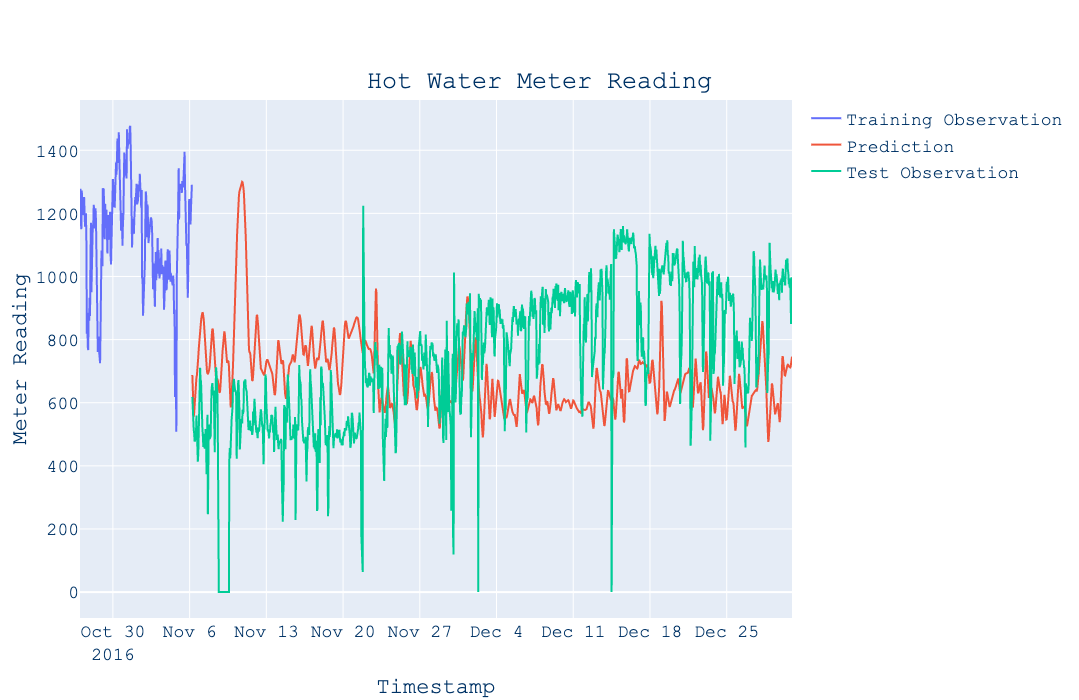

In [43]:
x = np.expand_dims(x_scaled_test, axis=0)
y_pred = hotwater_prediction_model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


y_train_reshaped = y_train.reshape((-1))
y_test_reshaped = y_test.reshape((-1))
y_pred_reshaped = y_pred_rescaled.reshape((-1))

trace1 = go.Scatter(
    x = hotwater_consumption.index[7200:num_train],
    y = y_train_reshaped,
    mode = 'lines',
    name = 'Training Observation'
)
trace2 = go.Scatter(
    x = date_test,
    y = y_pred_reshaped,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = y_test_reshaped,
    mode='lines',
    name = 'Test Observation'
)
layout = go.Layout(width=1400, height=700,
    title = {'text': "Hot Water Meter Reading", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis = {'title' : "Timestamp"},
    yaxis = {'title' : "Meter Reading", }
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.update_layout(font=dict(family="Courier New, monospace", size=18, color="#003366", )) # "#7f7f7f"
# fig.write_image('image/time_series_forcast_chw.png')
fig.show()

<h2 id="loss"><font color='darkblue'>Plot Model Loss</font></h2>

In [44]:
import visualization as vis
# vis.plot_train_vs_val_loss(history=elec_prediction_model, a='Electricity')

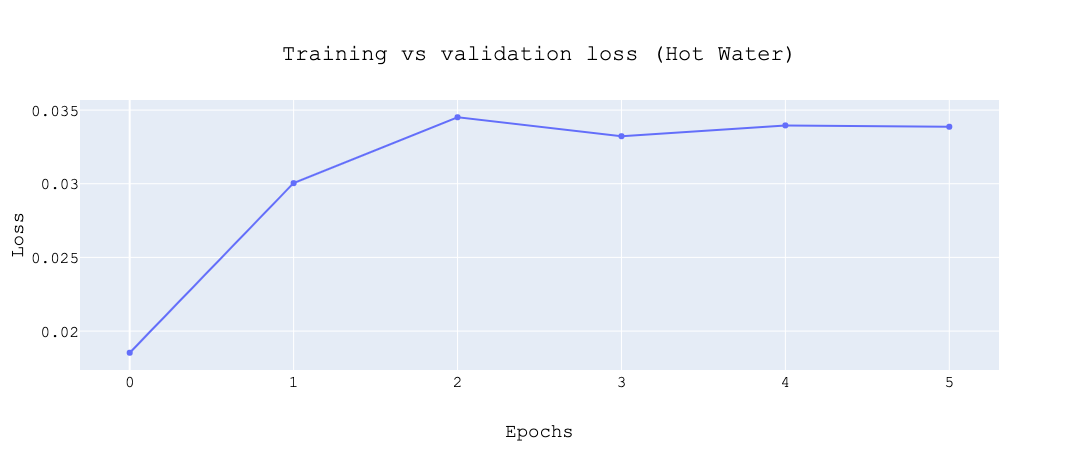

In [44]:
vis.plot_train_vs_val_loss(history=hotwater_dropout_history, a='Hot Water')

let's now calculate <b>MAE</b>, <b>MAPE</b>, and <b>RMSE</b>

In [46]:
f.calculate_errors(train=False, model=hotwater_prediction_model, x_scaled_train=x_scaled_train,
                  x_scaled_test=x_scaled_test, y_train=y_train, y_test=y_test, y_scaler=y_scaler,
                  target_names=target_variable)

Testing data:
    Mean Absolute Error: 251.45194225617155
    Mean Absolute Percent Error: 0.3363888937156804
    Root Mean Squared Error: 295.1961580578766


<h2 id="conclusion"><font color='darkblue'>Conclusion</font></h2>

<p>from the above two-layered LSTM prediction model, we were able to predict the feature (24-hours) electricity consumption prediction at 33.63% margin of MAPE. We can pretty much say our LSTM prediction model did a great job.<p>

The reason for a higher MAPE might be the model only see summer chilled water consumption data and tries to predict the chilled water demand in winter. Which might make the model pronto a higher error


<h2 id="feature works"><font color='darkblue'>Feature works...</font></h2>
<p>The organizer of this Kaggle competition only provides a one year worth of energy consumption data. The Pay-for-Perfomance (P4P) program, which I get my inspiration to do this work, requires three years of consumption data as a minimum. This work would be more applicable if I had three years of energy consumption data.</p>

<h3><strong>IMPORTANT TO NOTE:</strong></h3>
<p>This notebook is geared toward predicting electricity consumption of a use case office building. The same methodology is used to predict the feature chilled water, steam and electricity prediction as a separate notebook and they have numbered accordigly.</p>

                                                                    --- The END ---